<a href="https://colab.research.google.com/github/OkiHeo/python_machine_learning/blob/master/ch9_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHAPTER9 비지도 학습

데이터를 생성한다. 입력 데이터 X의 생성 과정에서 클래스 데이터 T3도 생성되지만, T3는 사용하지 않는다.

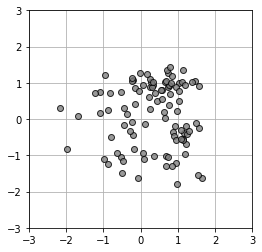

In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



#----------- 데이터 생성
np.random.seed(1)
N = 100         # 생성할 데이터의 개수
K = 3           # 클래스의 개수

T3 = np.zeros((N, 3), dtype=np.uint8)
X = np.zeros((N, 2))
X_range0 = [-3, 3]
X_range1 = [-3, 3]
X_col = ['cornflowerblue', 'black', 'white']            # 각 클래스를 나타낼 색을 지정

Mu = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]])        # 각 클래스 분포의 중심을 나타냄.
Sig = np.array([[.7, .7], [.8, .3], [.3, .8]])          # 각 클래스 분포의 분산을 나타냄.
Pi = np.array([0.4, 0.8, 1])                            # 각 클래스에 속할 누적 확률을 나타냄.

for n in range(N):
    wk = np.random.rand()
    # n개의 생성된 랜덤 데이터에 대해 1-of-K 부호화하여 T3에 저장
    for k in range(K):
        if wk<Pi[k]:
            T3[n, k] = 1
            break

    # 2차원 데이터 X의 [n, 0]: x좌표, [n, 1]: y좌표에 분포의 중심, 분산을 이용해서 위치 할당.
    for k in range(2):
        X[n, k] = (np.random.randn() * Sig[ T3[n, :]==1, k ] + Mu[ T3[n, :]==1, k ])




# ----------------- 데이터 그림으로 나타내기
def show_data(x):
    plt.plot( x[:, 0], x[:, 1], linestyle='none', 
             marker='o', markersize=6, 
             markeredgecolor='black', color='gray', alpha=0.8)
    plt.grid(True)



# -------------------- 메인
plt.figure(1, figsize=(4, 4))
show_data(X)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()

np.savez('data_ch9.npz', X=X, X_range0=X_range0, X_range1=X_range1)     # 생성된 데이터를 파일에 저장.

In [0]:
Mu = np.array([[-2, 1], [-2, 0], [-2 ,-1]])
R = np.c_[np.ones((N, 1)), np.zeros((N, 2), dtype=int)]     # 모든 데이터가 클래스 0에 속하도록 초기화한다.  

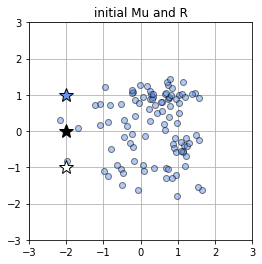

In [24]:
# ------------- 데이터를 그리는 함수
def show_prm(x, r, mu, col):
    for k in range(K):
        # 데이터 분포의 표시
        plt.plot(x[r[:, k]==1, 0], x[r[:, k]==1, 1], marker='o', markerfacecolor=X_col[k], markeredgecolor='k', markersize=6, alpha=0.5, linestyle='none')
        # 데이터 평균을 '★'로 표시
        plt.plot(mu[k, 0], mu[k, 1], marker='*', markerfacecolor=X_col[k], markersize=15, markeredgecolor='k', markeredgewidth=1)

    plt.xlim(X_range0)
    plt.ylim(X_range1)
    plt.grid(True)


# -----------------------------------
plt.figure(figsize=(4, 4))
R = np.c_[np.ones((N, 1)), np.zeros((N, 2))]        # 초기값, 전부 0클래스에 속함.
show_prm(X, R, Mu, X_col)
plt.title('initial Mu and R')
plt.show()

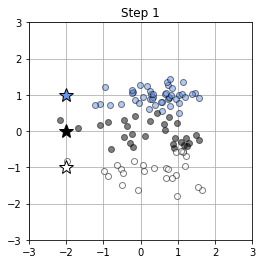

In [26]:
# r을 정한다. (step1 )----------------
def step1_kmeans(x0, x1, mu):
    N = len(x0)
    r = np.zeros((N, K))
    for n in range(N):      # N개의 데이터에 대해 반복.
        wk = np.zeros(K)    
        for k in range(K):  # K개의 클래스에 대해 반복. 어느 클래스와의 중심거리가 가장 짧은가?
            wk[k] = (x0[n]-mu[k, 0])**2 + (x1[n]-mu[k, 1])**2
        r[n, np.argmin(wk)]=1       # n, wk 중 가장 작은 값을 가지는 열에 1을 저장.
    return r



# ---------------------------------------
plt.figure(figsize=(4, 4))
R = step1_kmeans(X[:, 0], X[:, 1], Mu)
show_prm(X, R, Mu, X_col)
plt.title('Step 1')
plt.show()

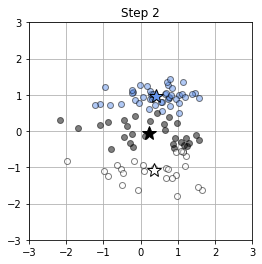

In [27]:
# Mu 결정 (Step 2) ---------------
def step2_kmeans(x0, x1, r):
    mu = np.zeros((K, 2))
    for k in range(K):      # K개의 클래스에 대해
        mu[k, 0] = np.sum(r[:, k]*x0) / np.sum(r[:, k])         # 클래스 k에 속하는 x좌표합 / 클래스 k에 속하는 x좌표개수
        mu[k, 1] = np.sum(r[:, k]*x1) / np.sum(r[:, k])         # 클래스 k에 속하는 y좌표합 / 클래스 k에 속하는 y좌표개수
    return mu


# --------------------------------수
plt.figure(figsize=(4, 4))
Mu = step2_kmeans(X[:, 0], X[:, 1], R)
show_prm(X, R, Mu, X_col)
plt.title('Step 2')
plt.show()

In [28]:
# 목적 함수 -------------------
def distortion_measure(x0, x1, r, mu):
    # 입력은 2차원으로 제한하고 있다.
    N = len(x0)
    J = 0

    for n in range(N):
        for k in range(K):
            J = J + r[n, k]*((x0[n]-mu[k, 0])**2 + (x1[n]-mu[k, 1])**2)
    return J


# test ----------------------------
# Mu 와 R을 초기화
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)]
distortion_measure(X[:, 0], X[:, 1], R, Mu)

771.7091170334878

[627.54  73.39  70.39  57.59  48.31  47.28  46.86  46.86  46.86  46.86]


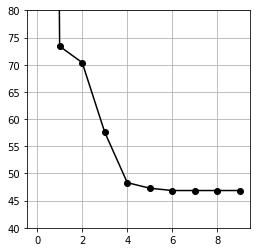

In [29]:
# Mu와 R의 초기화
N = X.shape[0]
K = 3

Mu = np.array([[-2, 1], [-2 ,0], [-2, -1]])
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)]

max_it = 10
it = 0

DM = np.zeros(max_it)       # 왜곡 척도의 계산 결과 저행

# K-means 기법 10번 반복 수행
for it in range(0, max_it):
    R = step1_kmeans(X[:, 0], X[:, 1], Mu)  # R의 갱신. 가장 중심이 가까운 클러스터로..
    DM[it] = distortion_measure(X[:, 0], X[:, 1], R, Mu)        # 왜곡 척도 계산.
    Mu = step2_kmeans(X[:, 0], X[:, 1], R)  # Mu의 갱신. 각 클러스터에 속하는 중심값 계산

print(np.round(DM, 2))
plt.figure(2, figsize=(4, 4))
plt.plot(DM, color='black', linestyle='-', marker='o')
plt.ylim(40, 80)
plt.grid(True)
plt.show()

## 가우시안 혼합 모델

In [38]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [0]:
### 앞에서 사용했던 X, X_range0, X_range1은 그대로 사용한다. load하자.
import numpy as np
wk = np.load('data_ch9.npz')

X = wk['X']
X_range0 = wk['X_range0']
X_range1 = wk['X_range1']

가우스 함수 gauss(x, mu, sigma) 정의.

In [0]:
# 가우스 함수 ------------------------
# x : NxD 행렬
# mu : 길이 D인 중심 벡터
# sigma : DxD의 공분산 행렬

def gauss(x, mu, sigma):
    N, D = x.shape          # x는 NxD의 행렬.
    c1 = 1/(2*np.pi)**(D/2)
    c2 = 1/ (np.linalg.det(sigma)**(1/2))
    inv_sigma = np.linalg.inv(sigma)
    c3 = x-mu
    c4 = np.dot(c3, inv_sigma)
    c5 = np.zeros(N)

    for d in range(D):
        c5 = c5 + c4[:, d] * c3[:, d]
    
    p = c1 * c2 * np.exp(-c5/2)
    return p

In [0]:
# 가우시안 혼합 모델 --------------------------------
# x : NxD 행렬
# pi : 혼합 계수. 길이 K의 벡터
# mu : KxD의 행렬. K개의 가우스 함수의 중심을 한 번에 지정함.
# sigma : 공분산 행렬. KxDxD의 3차원 배열 변수로 K개의 가우스 함수의 공분산 행렬을 한꺼번에 지정.
def mixgauss(x, pi, mu, sigma):
    N, D = x.shape
    K = len(pi)
    p = np.zeros(N)
    
    for k in range(K):
        p = p + pi[k]*gauss(x, mu[k, :], sigma[k, :, :])
    return p

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

# 혼합 가우스 등고선 표시 ----------------------------
def show_contour_mixgauss(pi, mu, sigma):
    xn = 40         # 등고선 표시 해상도
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)

    xx0, xx1 = np.meshgrid(x0, x1)

    x = np.c_[np.reshape(xx0, xn*xn, 1), np.reshape(xx1, xn*xn, 1)]
    f = mixgauss(x, pi, mu, sigma)
    f = f.reshape(xn, xn)
    f = f.T         # transpose
    plt.contour(x0, x1, f, 10, colors='gray')



# 혼합 가우스 3D 표시 ----------------------------------
def show3d_mixgauss(ax, pi, mu, sigma):
    xn = 40         # 해상도
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)

    xx0, xx1 = np.meshgrid(x0, x1)

    x = np.c_[np.reshape(xx0, xn*xn, 1), np.reshape(xx1, xn*xn, 1)]
    f = mixgauss(x, pi, mu, sigma)
    f = f.reshape(xn, xn)
    f = f.T         # transpose
    ax.plot_surface(xx0, xx1, f, rstride=2, cstride=2, alpha=0.3, color='blue', edgecolor='black')

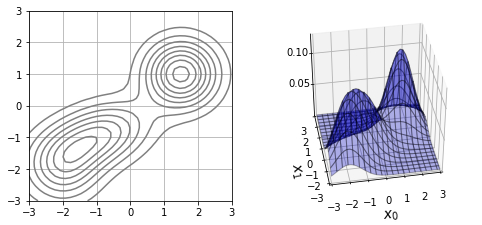

In [43]:
# test ---------------------------------------
pi = np.array([0.2, 0.4, 0.4])
mu = np.array([[-2, -2], [-1, -1], [1.5, 1]])
sigma = np.array([[[.5, 0], [0, .5]], 
                  [[1, 0.25], [0.25, .5]], 
                  [[.5, 0], [0, .5]]])

Fig = plt.figure(1, figsize=(8, 3.5))
Fig.add_subplot(1, 2, 1)
show_contour_mixgauss(pi, mu, sigma)
plt.grid(True)


Ax = Fig.add_subplot(1, 2, 2, projection='3d')
show3d_mixgauss(Ax, pi, mu, sigma)
Ax.set_zticks([0.05, 0.10])
Ax.set_xlabel('$x_0$', fontsize=14)
Ax.set_ylabel('$x_1$', fontsize=14)
Ax.view_init(40, -100)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()

## 9.3.3 EM 알고리즘의 개요

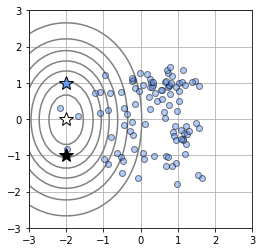

In [45]:
# 초기 설정 ---------------------------------
N = X.shape[0]
K = 3

Pi = np.array([0.33, 0.33, 0.34])               #클러스터 혼합 계수
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])     #클러스터 중심 벡터
Sigma = np.array([[[1, 0], [0, 1]],             #클러스터 공분산 행렬
                   [[1, 0], [0, 1]],
                   [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]


X_col = np.array([[0.4, 0.6, 0.95], [1, 1, 1], [0, 0, 0]])


# 데이터를 그림으로 나타내자 -------------------
def show_mixgauss_prm(x, gamma, pi, mu, sigma):
    N, D = x.shape
    show_contour_mixgauss(pi, mu, sigma)

    for n in range(N):
        col = gamma[n, 0]*X_col[0] + gamma[n, 1]*X_col[1] + gamma[n, 2]*X_col[2]
        plt.plot(x[n, 0], x[n, 1], 'o', color=tuple(col), markeredgecolor='black',
                 markersize=6, alpha=0.5)
        
    for k in range(K):
        plt.plot(mu[k, 0], mu[k, 1], marker='*',
                 markerfacecolor=tuple(X_col[k]), markersize=15,
                 markeredgecolor='k', markeredgewidth=1)
        
    plt.grid(True)


plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()